## Subscription Data

Author: Vivian

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [30]:
sub = pd.read_csv('/Users/vivianyan/Desktop/NYU_Capstone_Project/Data/XYZ_NETWORKS_SUB_1P_DATA.csv')
sub.describe(include='all')

,ID,BRAND,SUB_STATUS,TERM,AMOUNT,PARTITION_DATE
count,219218,250000,250000,250000,250000.000000,250000
unique,46247,5,4,3,NaN,730
top,301TUHW316,CineQuest,paid,monthly,NaN,2022-12-29
freq,28,74818,124780,162765,NaN,396
mean,NaN,NaN,NaN,NaN,31.133457,NaN
std,NaN,NaN,NaN,NaN,28.574427,NaN
min,NaN,NaN,NaN,NaN,2.400000,NaN
25%,NaN,NaN,NaN,NaN,11.990000,NaN
50%,NaN,NaN,NaN,NaN,20.000000,NaN
75%,NaN,NaN,NaN,NaN,49.990000,NaN


In [31]:
sub.head()

,ID,BRAND,SUB_STATUS,TERM,AMOUNT,PARTITION_DATE
0,042MSTJ610,CineQuest,trial,monthly,11.41,2022-10-09
1,020TBXH154,ChillStream,paid,monthly,25.00,2022-08-04
2,367MQHB590,Pulse,paid,monthly,8.01,2023-08-10
3,805HIRQ868,RetroReel,expired,annual,119.99,2023-11-05
4,150UITM842,LimeLight,paid,monthly,20.02,2022-03-02


### Data Cleaning
#### Fix Incorrectly Imputed `daily` Values:
<div class="alert alert-info">
Daily is an incorrectly imputed value for monthly. The only two valid values for term should be annual or monthly.
</div>

In [32]:
sub.TERM.unique()

array(['monthly', 'annual', 'daily'], dtype=object)

In [33]:
sub['TERM'] = sub['TERM'].replace('daily', 'monthly')
sub.TERM.unique()

array(['monthly', 'annual'], dtype=object)

#### Ensure No Duplicate Events per ID/Brand per Month:
<div class="alert alert-info">
No ID should have 2 events in the same month within a specific brand 

- This can be determined using the partition date field
</div>

In [34]:
sub['YEAR_MONTH'] = pd.to_datetime(sub['PARTITION_DATE']).dt.to_period('M')
sub.head()

,ID,BRAND,SUB_STATUS,TERM,AMOUNT,PARTITION_DATE,YEAR_MONTH
0,042MSTJ610,CineQuest,trial,monthly,11.41,2022-10-09,2022-10
1,020TBXH154,ChillStream,paid,monthly,25.00,2022-08-04,2022-08
2,367MQHB590,Pulse,paid,monthly,8.01,2023-08-10,2023-08
3,805HIRQ868,RetroReel,expired,annual,119.99,2023-11-05,2023-11
4,150UITM842,LimeLight,paid,monthly,20.02,2022-03-02,2022-03


In [35]:
sub.groupby(['ID', 'YEAR_MONTH', 'BRAND']).agg({'SUB_STATUS':'count'})['SUB_STATUS'].nunique()

1

In [36]:
sub.groupby(['ID', 'YEAR_MONTH', 'BRAND']).agg({'TERM':'count'})['TERM'].nunique()

1

In [37]:
# sub.drop_duplicates(subset=['ID', 'BRAND', 'MONTH_YEAR'], inplace=True)

#### Validate Allowed Transitions Between States:
<div class="alert alert-info">
Transition states will be relevant to SUB_STATUS and TERM columns

- Allowed states for SUB_STATUS:	 
    - trial: paid, expired
    - discounted: paid, expired
    - paid: expired
    - expired: paid, discounted, trial

- An ID who is trial/discounted/paid for one term type (monthly/annual) will need to expire before they can begin a new subscription with the alternative term type
    - i.e. if a sub for Y brand is paid/monthly, and then the next chronological row indicates they are trial/annual, this second transition should be flagged as incorrect and ignored from subscription duration and other calculations
</div>

In [38]:
allowed_transitions = {
    'trial': ['paid', 'expired'],
    'discounted': ['paid', 'expired'],
    'paid': ['expired'],
    'expired': ['paid', 'discounted', 'trial']
}

In [39]:
sub = sub.sort_values(by=['ID', 'BRAND', 'PARTITION_DATE']).reset_index(drop=True)
sub['VALID_TRANSITION'] = True

In [40]:
sub[sub.ID=='000AHHU956']

,ID,BRAND,SUB_STATUS,TERM,AMOUNT,PARTITION_DATE,YEAR_MONTH,VALID_TRANSITION
0,000AHHU956,RetroReel,expired,monthly,30.00,2022-02-17,2022-02,True
1,000AHHU956,RetroReel,paid,monthly,29.99,2022-05-21,2022-05,True
2,000AHHU956,RetroReel,paid,monthly,30.00,2022-08-25,2022-08,True
3,000AHHU956,RetroReel,trial,monthly,28.01,2023-03-09,2023-03,True
4,000AHHU956,RetroReel,paid,monthly,30.02,2023-07-08,2023-07,True
5,000AHHU956,RetroReel,expired,monthly,30.00,2023-10-28,2023-10,True
6,000AHHU956,RetroReel,trial,monthly,11.18,2023-11-05,2023-11,True
7,000AHHU956,RetroReel,discounted,monthly,25.89,2023-12-27,2023-12,True


<div class="alert alert-danger" role="alert">
Questions:

For user 000AHHU956:
1. row2 to row3: status remained unchanged? keep the first occurrence?
2. last row: no closure, status remained unchanged? any deadline or until now?

</div>

In [41]:
sub[sub.ID=='000DJKK225']

,ID,BRAND,SUB_STATUS,TERM,AMOUNT,PARTITION_DATE,YEAR_MONTH,VALID_TRANSITION
11,000DJKK225,CineQuest,expired,monthly,12.00,2022-04-15,2022-04,True
12,000DJKK225,CineQuest,expired,monthly,12.00,2022-06-21,2022-06,True
13,000DJKK225,CineQuest,paid,monthly,12.00,2022-07-17,2022-07,True
14,000DJKK225,CineQuest,paid,monthly,11.97,2022-10-15,2022-10,True
15,000DJKK225,CineQuest,paid,annual,60.00,2023-09-29,2023-09,True


<div class="alert alert-danger" role="alert">
Questions:

For user 000DJKK225:
1. row1 and row2: two expires? keep the latest one?
</div>

In [42]:
sub[sub.ID=='042MSTJ610']

,ID,BRAND,SUB_STATUS,TERM,AMOUNT,PARTITION_DATE,YEAR_MONTH,VALID_TRANSITION
9307,042MSTJ610,CineQuest,expired,annual,59.99,2022-01-29,2022-01,True
9308,042MSTJ610,CineQuest,paid,annual,60.01,2022-02-06,2022-02,True
9309,042MSTJ610,CineQuest,paid,annual,59.99,2022-08-26,2022-08,True
9310,042MSTJ610,CineQuest,trial,monthly,11.41,2022-10-09,2022-10,True
9311,042MSTJ610,CineQuest,expired,monthly,12.00,2022-11-16,2022-11,True


<div class="alert alert-danger" role="alert">
Questions:

For user 042MSTJ610:
1. row1 and row2: paid after expired?
2. row-2 to row-1: can we skip "paid"? or should be strictly followed by the assigend transition table except for "expired"?

</div>

#### Full Dataset

In [43]:
# Validate transitions for each user within each brand
prev, curr = 0, 1
while curr < len(sub):    
    if sub.iloc[curr]['ID'] == sub.iloc[prev]['ID'] and sub.iloc[curr]['BRAND'] == sub.iloc[prev]['BRAND']:
        prev_status, curr_status = sub.iloc[prev]['SUB_STATUS'], sub.iloc[curr]['SUB_STATUS']
        prev_term, curr_term = sub.iloc[prev]['TERM'], sub.iloc[curr]['TERM']

        if curr_status not in allowed_transitions[prev_status]:
            sub.at[curr, 'VALID_TRANSITION'] = False
            curr += 1
            continue

        if curr_term != prev_term and prev_status != 'expired':
            sub.at[curr, 'VALID_TRANSITION'] = False
            curr += 1
            continue

        if curr_term == prev_term and curr_status == prev_status:
            sub.at[curr, 'VALID_TRANSITION'] = False
            curr += 1
            continue

        prev = curr
        curr += 1

    else:
        prev = curr
        curr += 1

KeyboardInterrupt: 

#### Remove Missing Values (ID only):
<div class="alert alert-info">
If data is missing between partition date events for an individual, you can assume there status has remained unchanged/the same until the next valid transition 
</div>

In [17]:
sub_filtered = sub[sub['VALID_TRANSITION'] == True]
sub_filtered.dropna(how='any', inplace=True)
sub_filtered.describe(include='all')

/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_76000/4147286684.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_filtered.dropna(how='any', inplace=True)


,ID,BRAND,SUB_STATUS,TERM,AMOUNT,PARTITION_DATE,YEAR_MONTH,VALID_TRANSITION
count,132587,132587,132587,132587,132587.000000,132587,132587,132587
unique,46247,5,4,2,NaN,730,24,1
top,064PYQT737,CineQuest,paid,monthly,NaN,2022-01-26,2022-01,True
freq,18,33572,66089,95546,NaN,328,9294,132587
mean,NaN,NaN,NaN,NaN,32.478291,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,29.636835,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,2.410000,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,11.990000,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,20.010000,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,49.990000,NaN,NaN,NaN


In [18]:
print('Filtered SUB Data Shape: ', sub_filtered.shape)
print('SUB Data Shape: ', sub.shape)

Filtered SUB Data Shape:  (132587, 8)
SUB Data Shape:  (250000, 8)


#### Split data
<div class="alert alert-info">
train:

- X (2022-01-01 to 2022-12-31)
- y (2023-01-01 to 2023-06-30)

test: 
- X (2022-06-01 to 2023-06-30)
- y (2023-07-01 to 2023-12-31)

predict: 
- X (2023-01-01 to 2023-12-31)
- y (2024-01 to 2024-06)
</div>

In [19]:
sub_filtered['PARTITION_DATE'] = pd.to_datetime(sub_filtered['PARTITION_DATE'])
sub_filtered = sub_filtered.reset_index(drop=True)
sub_filtered.head()

/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_76000/3221119947.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_filtered['PARTITION_DATE'] = pd.to_datetime(sub_filtered['PARTITION_DATE'])


,ID,BRAND,SUB_STATUS,TERM,AMOUNT,PARTITION_DATE,YEAR_MONTH,VALID_TRANSITION
0,000AHHU956,RetroReel,expired,monthly,30.00,2022-02-17,2022-02,True
1,000AHHU956,RetroReel,paid,monthly,29.99,2022-05-21,2022-05,True
2,000AHHU956,RetroReel,expired,monthly,30.00,2023-10-28,2023-10,True
3,000AHHU956,RetroReel,trial,monthly,11.18,2023-11-05,2023-11,True
4,000BRHY264,CineQuest,paid,annual,60.00,2022-05-23,2022-05,True


In [20]:
train_X = sub_filtered[(sub_filtered['PARTITION_DATE']>='2022-01-01') & (sub_filtered['PARTITION_DATE']<='2022-12-31')]
test_X = sub_filtered[(sub_filtered['PARTITION_DATE']>='2022-06-01') & (sub_filtered['PARTITION_DATE']<='2023-06-30')]
predict_X = sub_filtered[(sub_filtered['PARTITION_DATE']>='2023-01-01') & (sub_filtered['PARTITION_DATE']<='2023-12-31')]

train_y = sub_filtered[(sub_filtered['PARTITION_DATE']>='2023-01-01') & (sub_filtered['PARTITION_DATE']<='2023-06-30')]
test_y = sub_filtered[(sub_filtered['PARTITION_DATE']>='2023-07-01') & (sub_filtered['PARTITION_DATE']<='2023-12-31')]
# predict_y = np.where(id_brand_agg.between_time('2024-01-01','2024-06-30'))

In [21]:
print('train X shape: ', train_X.shape)
print('test X shape: ', test_X.shape)
print('predict X shape: ', predict_X.shape)
print('train y shape: ', train_y.shape)
print('test y shape: ', test_y.shape)

train X shape:  (76818, 8)
test X shape:  (67131, 8)
predict X shape:  (55769, 8)
train y shape:  (28286, 8)
test y shape:  (27483, 8)


In [22]:
train_X.to_csv('data_preprocessing/train_x.csv')
test_X.to_csv('data_preprocessing/test_x.csv')
predict_X.to_csv('data_preprocessing/predict_x.csv')
train_y.to_csv('data_preprocessing/train_y.csv')
test_y.to_csv('data_preprocessing/test_y.csv')

#### Calculate duration & revenue per subscription term based on valid transitions:
<div class="alert alert-info">
Subscription start and end date are not provided. Instead partition date (symbolizes when data is refreshed) is provided. 

- You can use partition date as a proxy to calculate the length of duration of a subscription for a specific id (this can be determined by ensuring rows adhere to certain transition states)
</div>

##### train_X: 2022-01-01 to 2022-12-31

In [44]:
train_X = pd.read_csv('data_preprocessing/train_x.csv')
train_X['PARTITION_DATE'] = pd.to_datetime(train_X['PARTITION_DATE'])

In [45]:
agg_train_X_data = []
grouped = train_X.groupby(['ID', 'BRAND'])

for (id_brand, group) in grouped:
    group = group.reset_index(drop=True)

    start_date = pd.to_datetime('2022-01-01')
    end_date = pd.to_datetime('2022-12-31')
    sub_detail = ''
    revenue = 0
    amount = 0
    
    for i, row in group.iterrows():
        sub_status = row['SUB_STATUS']
        partition_date = row['PARTITION_DATE']

        if sub_status in ['trial', 'discounted', 'paid'] and start_date == pd.to_datetime('2022-01-01'):
            start_date = partition_date
            sub_detail = row['SUB_STATUS'] + ' ' + row['TERM']
            
            if sub_status in ['trial', 'discounted']:
                amount = row['AMOUNT']
            elif sub_status == 'paid' and amount != 0: 
                if row['TERM'] == 'monthly':
                    revenue += np.ceil(duration / 30) * amount
                else:
                    revenue += np.ceil(duration / 365) * amount
                amount = row['AMOUNT']
            
        if sub_status == 'expired':
            end_date = partition_date
            duration = (end_date - start_date).days
            if start_date == pd.to_datetime('2022-01-01'):
                sub_detail = row['SUB_STATUS'] + ' ' + row['TERM']

            if row['TERM'] == 'monthly':
                revenue += np.ceil(duration / 30) * row['AMOUNT']
            else:
                revenue += np.ceil(duration / 365) * row['AMOUNT']
            
            agg_train_X_data.append({
                'ID': id_brand[0],
                'BRAND': id_brand[1],
                'SUB_DETAIL': sub_detail,
                'START_DATE': start_date,
                'END_DATE': end_date,
                'SUB_DURATION_DAYS': duration,
                'REVENUE': revenue
            })            
            start_date = pd.to_datetime('2022-01-01')

agg_train_X = pd.DataFrame(agg_train_X_data)
agg_train_X.head()

,ID,BRAND,SUB_DETAIL,START_DATE,END_DATE,SUB_DURATION_DAYS,REVENUE
0,000AHHU956,RetroReel,expired monthly,2022-01-01,2022-02-17,47,60.00
1,000DJKK225,CineQuest,expired monthly,2022-01-01,2022-04-15,104,48.00
2,000DTPC747,LimeLight,expired annual,2022-01-01,2022-08-01,212,80.00
3,000ORNZ823,CineQuest,expired monthly,2022-01-01,2022-04-24,113,48.04
4,000ORNZ823,CineQuest,discounted monthly,2022-05-01,2022-10-07,159,119.98


In [46]:
print(train_X.shape, agg_train_X.shape)

(76818, 9) (27086, 7)


In [47]:
agg_train_X.isnull().any()

ID                   False
BRAND                False
SUB_DETAIL           False
START_DATE           False
END_DATE             False
SUB_DURATION_DAYS    False
REVENUE              False
dtype: bool

In [48]:
agg_train_X.describe(include='all')

,ID,BRAND,SUB_DETAIL,START_DATE,END_DATE,SUB_DURATION_DAYS,REVENUE
count,27086,27086,27086,27086,27086,27086.000000,27086.000000
unique,22688,5,8,NaN,NaN,NaN,NaN
top,453GLDT300,CineQuest,expired monthly,NaN,NaN,NaN,NaN
freq,5,7521,10204,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,2022-02-14 12:35:43.572325376,2022-06-16 12:52:47.510891264,122.011851,82.494087
min,NaN,NaN,NaN,2022-01-01 00:00:00,2022-01-01 00:00:00,0.000000,0.000000
25%,NaN,NaN,NaN,2022-01-01 00:00:00,2022-03-14 00:00:00,48.000000,40.000000
50%,NaN,NaN,NaN,2022-01-01 00:00:00,2022-06-08 00:00:00,102.000000,63.840000
75%,NaN,NaN,NaN,2022-03-12 00:00:00,2022-09-16 00:00:00,181.000000,100.040000
max,NaN,NaN,NaN,2022-11-30 00:00:00,2022-12-31 00:00:00,364.000000,482.010000


In [98]:
agg_train_X.to_csv('data_preprocessing/train_x_duration_revenue.csv')

Total revenue per user per brand: combine across each subscription term
- where `DATE` is the last active date of the user within the brand

In [109]:
current_date = pd.to_datetime("2022-12-31")
train_x_rfm = agg_train_X.groupby(["ID", "BRAND"], as_index=False).agg(
    RECENCY = ("END_DATE", lambda x: (current_date - x.max()).days),
    FREQUENCY = ('BRAND', 'nunique'),
    REVENUE = ("REVENUE", "sum"),
    SUB = ('SUB_DETAIL', lambda x: list(x)),
    DATE = ("END_DATE", lambda x: x.max())
)
train_x_rfm.head()

,ID,BRAND,RECENCY,FREQUENCY,REVENUE,SUB,DATE
0,000AHHU956,RetroReel,317,1,60.00,[expired monthly],2022-02-17
1,000DJKK225,CineQuest,260,1,48.00,[expired monthly],2022-04-15
2,000DTPC747,LimeLight,152,1,80.00,[expired annual],2022-08-01
3,000ORNZ823,CineQuest,85,1,168.02,"[expired monthly, discounted monthly]",2022-10-07
4,000QBES821,CineQuest,134,1,36.03,[paid monthly],2022-08-19


In [110]:
train_x_rfm.to_csv('data_preprocessing/train_x_rfm.csv')

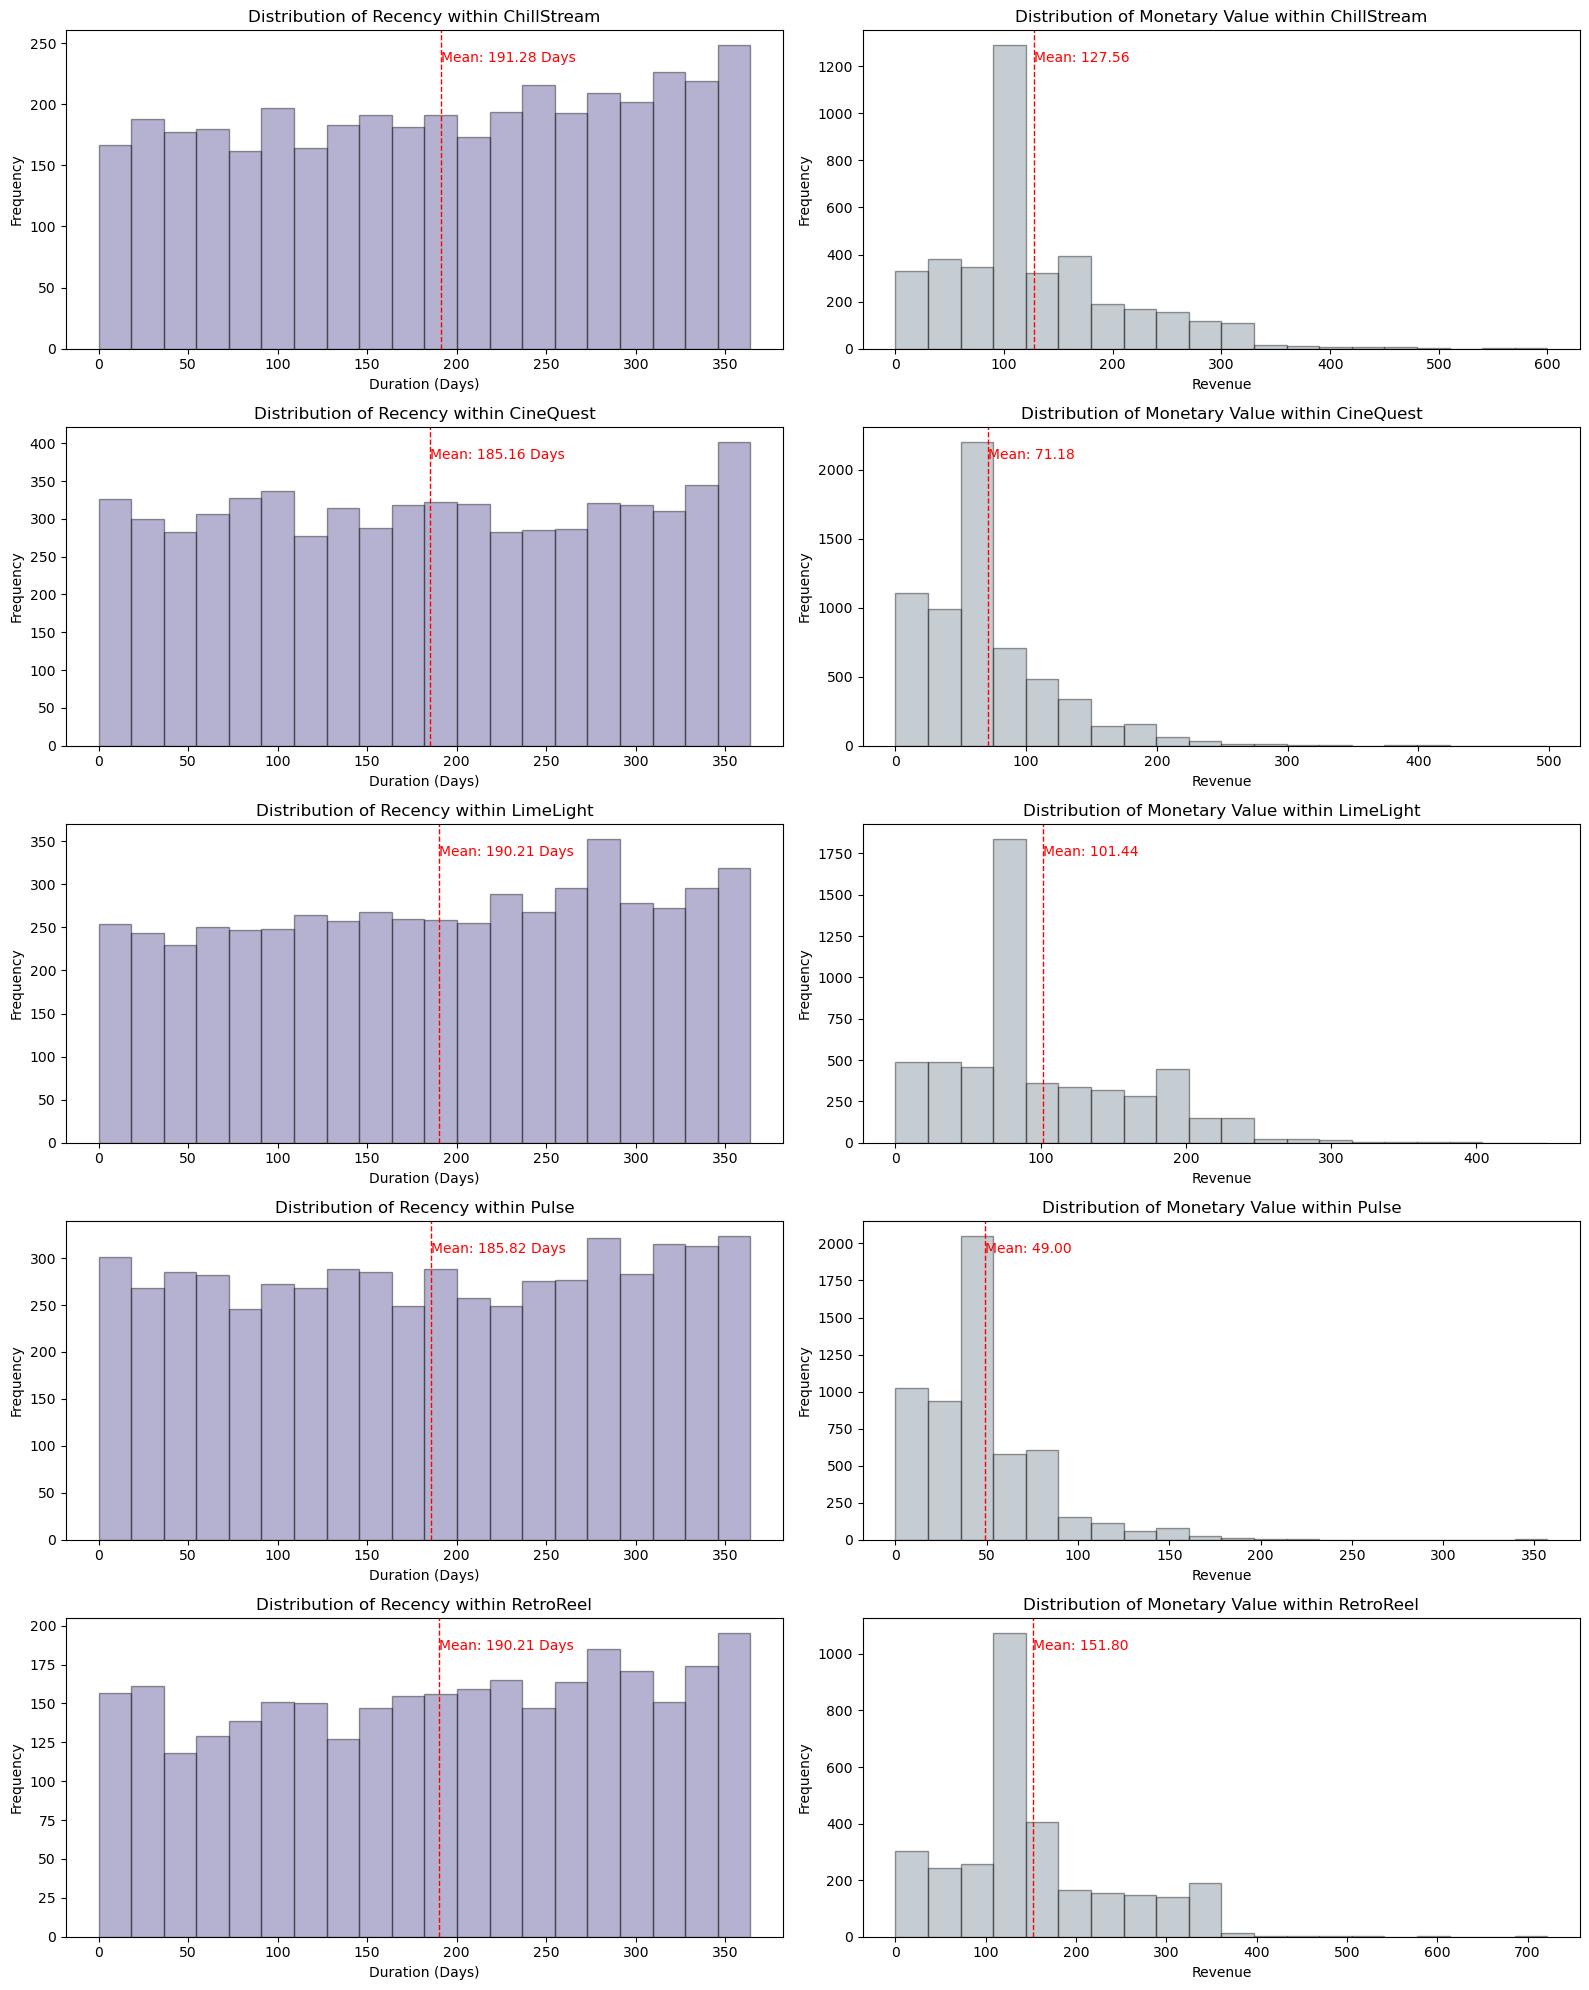

In [52]:
nrows, ncols = 5, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 20))
fig.tight_layout(pad=5.0)  # Add spacing between plots

train_x_brand_grouped = train_x_rfm.groupby('BRAND')

for (ax1, ax2), (brand, brand_group) in zip(axes, train_x_brand_grouped):
    brand_group = brand_group.reset_index(drop=True)
    
    avg_recency_brand = np.mean(brand_group['RECENCY'])
    ax1.hist(brand_group['RECENCY'], color='darkslateblue', alpha=0.4, bins=20, edgecolor='black')
    ax1.axvline(avg_recency_brand, color='r', linestyle='dashed', linewidth=1)
    ax1.text(avg_recency_brand, ax1.get_ylim()[1] * 0.9, 
                   f'Mean: {avg_recency_brand:.2f} Days', color='r')
    ax1.set_title('Distribution of Recency within ' + str(brand))
    ax1.set_xlabel('Duration (Days)')
    ax1.set_ylabel('Frequency')

    avg_revenue_brand = np.mean(brand_group['REVENUE'])
    ax2.hist(brand_group['REVENUE'], color='slategrey', alpha=0.4, bins=20, edgecolor='black')
    ax2.axvline(avg_revenue_brand, color='r', linestyle='dashed', linewidth=1)
    ax2.text(avg_revenue_brand, ax2.get_ylim()[1] * 0.9, f'Mean: {avg_revenue_brand:.2f}', color='r')
    ax2.set_title('Distribution of Monetary Value within ' + str(brand))
    ax2.set_xlabel('Revenue')
    ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

##### train y: 2023-01-01 to 2023-06-30

In [53]:
train_y = pd.read_csv('data_preprocessing/train_y.csv')
train_y['PARTITION_DATE'] = pd.to_datetime(train_y['PARTITION_DATE'])

In [54]:
agg_train_y_data = []
grouped_train_y = train_y.groupby(['ID', 'BRAND'])

for (id_brand, group) in grouped_train_y:
    group = group.reset_index(drop=True)

    start_date = pd.to_datetime('2023-01-01')
    end_date = pd.to_datetime('2023-06-30')
    sub_detail = ''
    revenue = 0
    amount = 0
    
    for i, row in group.iterrows():
        sub_status = row['SUB_STATUS']
        partition_date = row['PARTITION_DATE']

        if sub_status in ['trial', 'discounted', 'paid'] and start_date == pd.to_datetime('2023-01-01'):
            start_date = partition_date
            sub_detail = row['SUB_STATUS'] + ' ' + row['TERM']
            
            if sub_status in ['trial', 'discounted']:
                amount = row['AMOUNT']
            elif sub_status == 'paid' and amount != 0: 
                if row['TERM'] == 'monthly':
                    revenue += np.ceil(duration / 30) * amount
                else:
                    revenue += np.ceil(duration / 365) * amount
                amount = row['AMOUNT']
            
        if sub_status == 'expired':
            end_date = partition_date
            duration = (end_date - start_date).days
            if start_date == pd.to_datetime('2023-01-01'):
                sub_detail = row['SUB_STATUS'] + ' ' + row['TERM']

            if row['TERM'] == 'monthly':
                revenue += np.ceil(duration / 30) * row['AMOUNT']
            else:
                revenue += np.ceil(duration / 365) * row['AMOUNT']
            
            agg_train_y_data.append({
                'ID': id_brand[0],
                'BRAND': id_brand[1],
                'SUB_DETAIL': sub_detail,
                'START_DATE': start_date,
                'END_DATE': end_date,
                'SUB_DURATION_DAYS': duration,
                'REVENUE': revenue
            })            
            start_date = pd.to_datetime('2023-01-01')

agg_train_y = pd.DataFrame(agg_train_y_data)
agg_train_y.head()

,ID,BRAND,SUB_DETAIL,START_DATE,END_DATE,SUB_DURATION_DAYS,REVENUE
0,000ELOE240,LimeLight,expired annual,2023-01-01,2023-04-25,114,80.01
1,000GTIY258,Pulse,expired monthly,2023-01-01,2023-01-03,2,7.98
2,000LZCB553,RetroReel,expired monthly,2023-01-01,2023-01-13,12,30.00
3,000ORNZ823,CineQuest,paid monthly,2023-02-09,2023-03-13,32,24.00
4,000PGCL630,RetroReel,expired monthly,2023-01-01,2023-05-05,124,150.05


In [55]:
print(train_y.shape, agg_train_y.shape)

(28286, 9) (10978, 7)


In [56]:
agg_train_y.isnull().any()

ID                   False
BRAND                False
SUB_DETAIL           False
START_DATE           False
END_DATE             False
SUB_DURATION_DAYS    False
REVENUE              False
dtype: bool

In [57]:
agg_train_y.describe(include='all')

,ID,BRAND,SUB_DETAIL,START_DATE,END_DATE,SUB_DURATION_DAYS,REVENUE
count,10978,10978,10978,10978,10978,10978.000000,10978.000000
unique,10461,5,8,NaN,NaN,NaN,NaN
top,659LKRY365,CineQuest,expired monthly,NaN,NaN,NaN,NaN
freq,3,3016,6920,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,2023-01-08 20:57:08.821278976,2023-03-31 00:20:35.634906368,81.141283,60.017260
min,NaN,NaN,NaN,2023-01-01 00:00:00,2023-01-01 00:00:00,0.000000,0.000000
25%,NaN,NaN,NaN,2023-01-01 00:00:00,2023-02-14 00:00:00,38.000000,30.000000
50%,NaN,NaN,NaN,2023-01-01 00:00:00,2023-03-30 00:00:00,77.000000,50.010000
75%,NaN,NaN,NaN,2023-01-01 00:00:00,2023-05-15 00:00:00,123.000000,80.000000
max,NaN,NaN,NaN,2023-05-31 00:00:00,2023-06-30 00:00:00,180.000000,224.930000


In [97]:
agg_train_y.to_csv('data_preprocessing/train_y_duration_revenue.csv')

In [106]:
current_date = pd.to_datetime("2023-06-30")
train_y_rfm = agg_train_y.groupby(["ID", "BRAND"], as_index=False).agg(
    RECENCY = ("END_DATE", lambda x: (current_date - x.max()).days),
    FREQUENCY = ('BRAND', 'nunique'),
    REVENUE = ("REVENUE", "sum"),
    SUB = ('SUB_DETAIL', lambda x: list(x)),
    DATE = ("END_DATE", lambda x: x.max())
)
train_y_rfm.head()

,ID,BRAND,RECENCY,FREQUENCY,REVENUE,SUB,DATE
0,000ELOE240,LimeLight,66,1,80.01,[expired annual],2023-04-25
1,000GTIY258,Pulse,178,1,7.98,[expired monthly],2023-01-03
2,000LZCB553,RetroReel,168,1,30.00,[expired monthly],2023-01-13
3,000ORNZ823,CineQuest,109,1,24.00,[paid monthly],2023-03-13
4,000PGCL630,RetroReel,56,1,150.05,[expired monthly],2023-05-05


In [107]:
train_y_rev = train_y_rfm['REVENUE']
train_y_rev.head()

0     80.01
1      7.98
2     30.00
3     24.00
4    150.05
Name: REVENUE, dtype: float64

In [108]:
train_y_rfm.to_csv('data_preprocessing/train_y_rfm.csv')

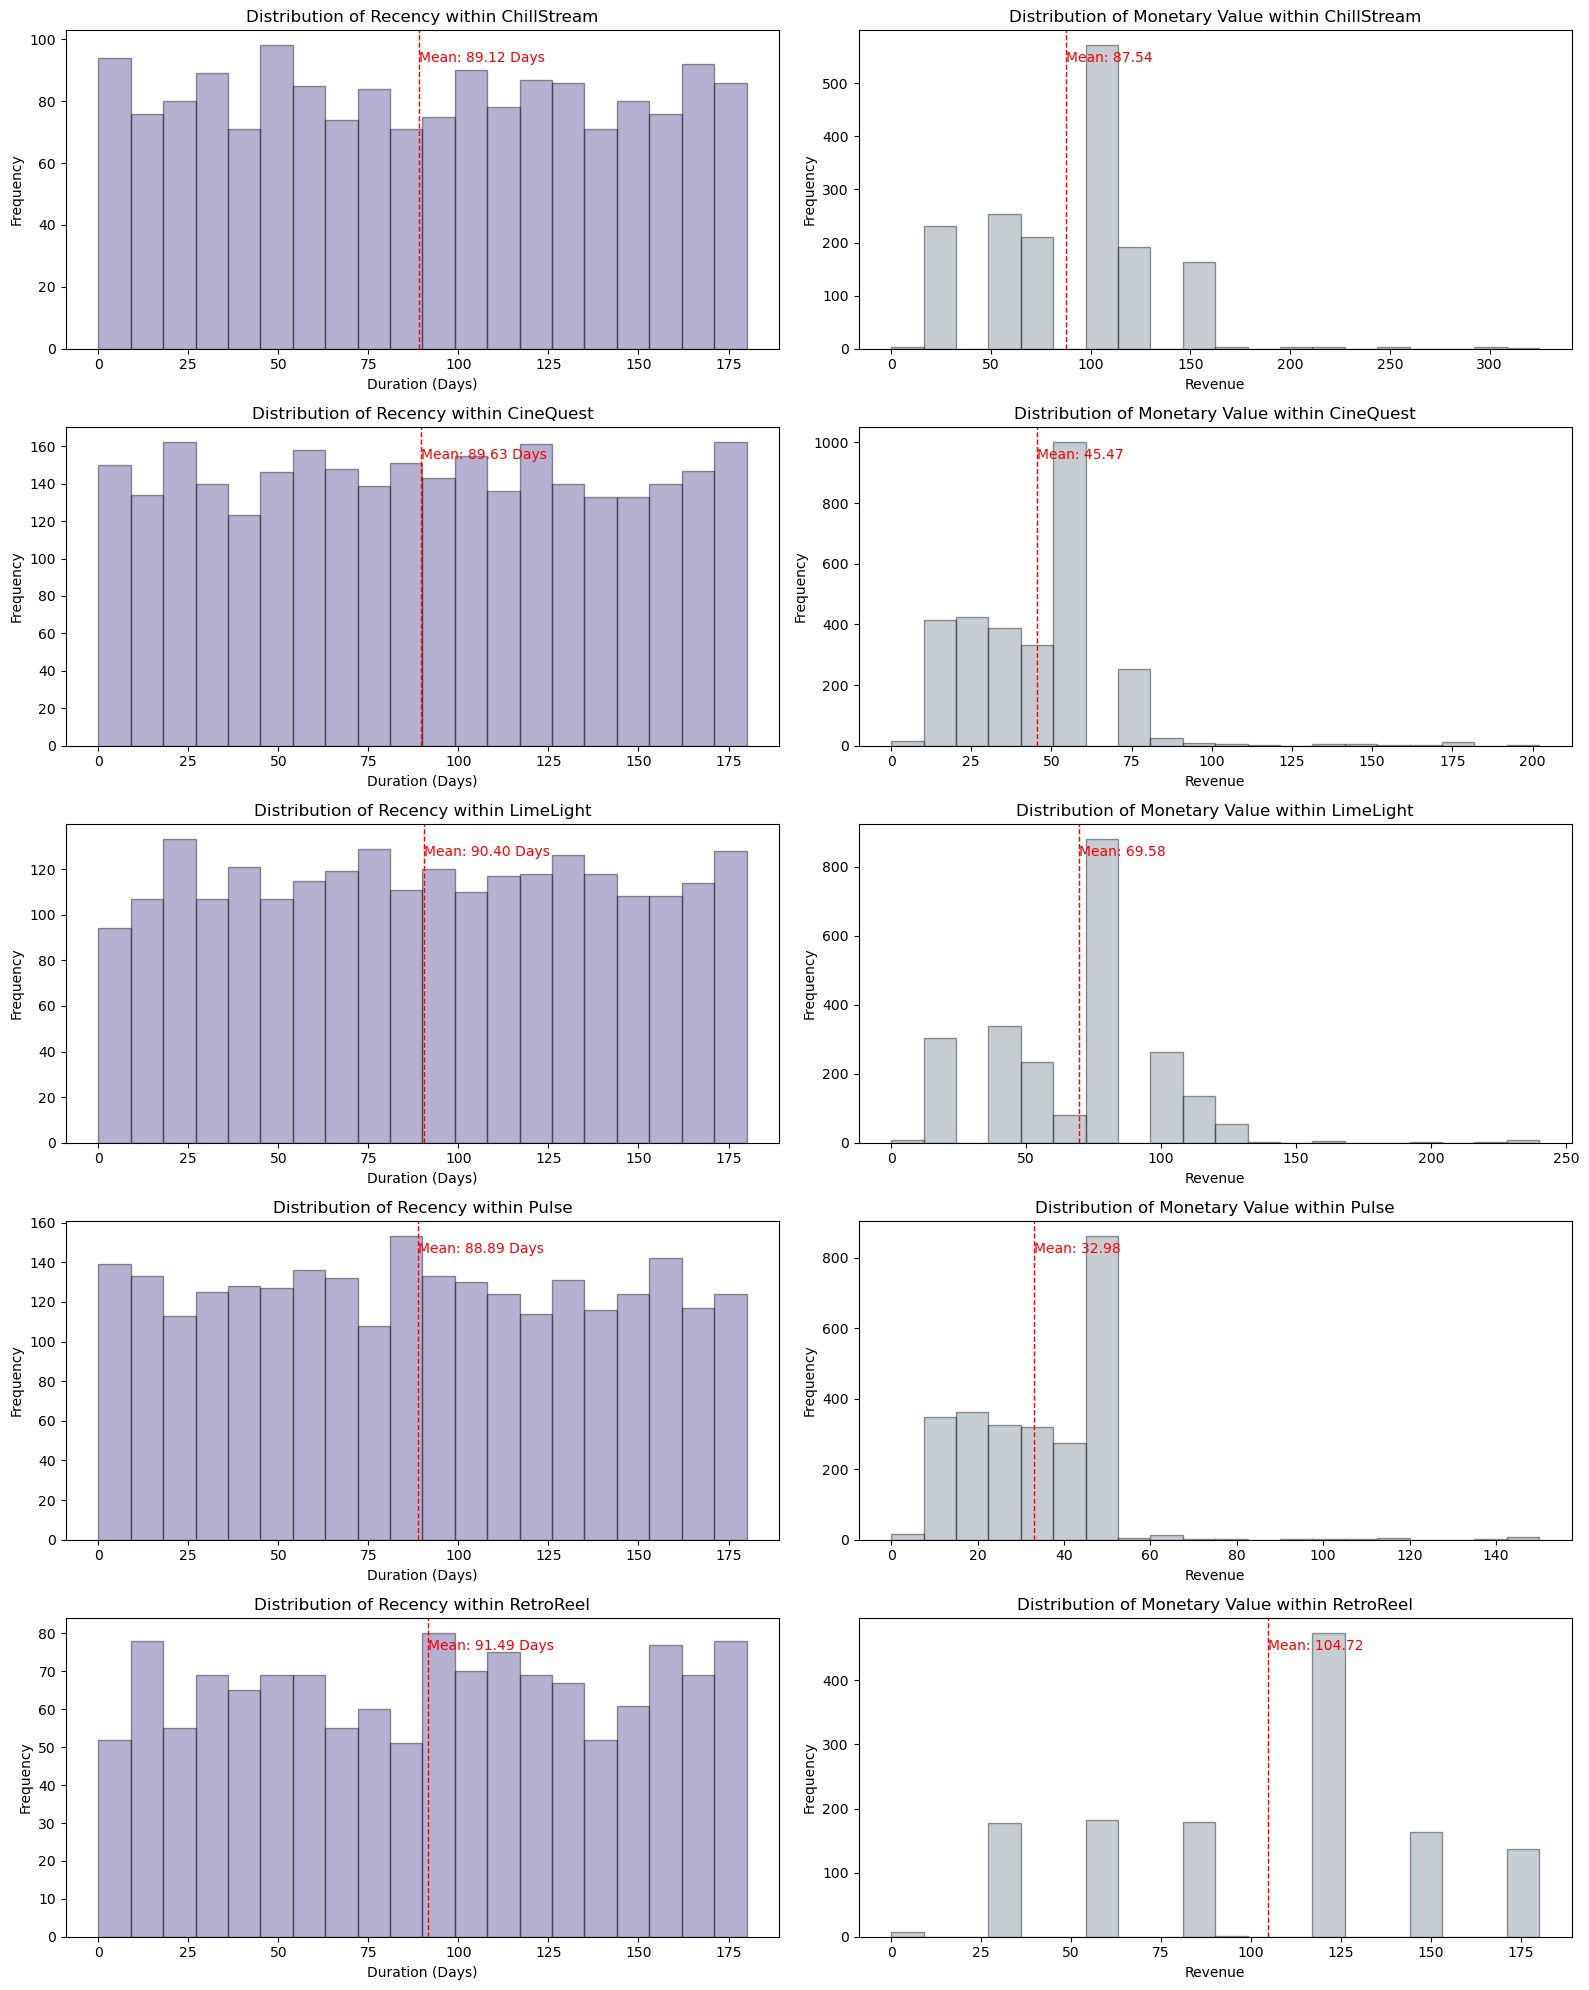

In [62]:
nrows, ncols = 5, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 20))
fig.tight_layout(pad=5.0)  # Add spacing between plots

train_y_brand_grouped = train_y_rfm.groupby('BRAND')

for (ax1, ax2), (brand, brand_group) in zip(axes, train_y_brand_grouped):
    brand_group = brand_group.reset_index(drop=True)
    
    avg_recency_brand = np.mean(brand_group['RECENCY'])
    ax1.hist(brand_group['RECENCY'], color='darkslateblue', alpha=0.4, bins=20, edgecolor='black')
    ax1.axvline(avg_recency_brand, color='r', linestyle='dashed', linewidth=1)
    ax1.text(avg_recency_brand, ax1.get_ylim()[1] * 0.9, 
                   f'Mean: {avg_recency_brand:.2f} Days', color='r')
    ax1.set_title('Distribution of Recency within ' + str(brand))
    ax1.set_xlabel('Duration (Days)')
    ax1.set_ylabel('Frequency')

    avg_revenue_brand = np.mean(brand_group['REVENUE'])
    ax2.hist(brand_group['REVENUE'], color='slategrey', alpha=0.4, bins=20, edgecolor='black')
    ax2.axvline(avg_revenue_brand, color='r', linestyle='dashed', linewidth=1)
    ax2.text(avg_revenue_brand, ax2.get_ylim()[1] * 0.9, f'Mean: {avg_revenue_brand:.2f}', color='r')
    ax2.set_title('Distribution of Monetary Value within ' + str(brand))
    ax2.set_xlabel('Revenue')
    ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

##### test X: 2022-06-01 to 2023-06-30

In [63]:
test_X = pd.read_csv('data_preprocessing/test_X.csv')
test_X['PARTITION_DATE'] = pd.to_datetime(test_X['PARTITION_DATE'])

In [64]:
agg_test_x_data = []
grouped_test_x = test_X.groupby(['ID', 'BRAND'])

for (id_brand, group) in grouped_test_x:
    group = group.reset_index(drop=True)

    start_date = pd.to_datetime('2022-06-01')
    end_date = pd.to_datetime('2023-06-30')
    sub_detail = ''
    revenue = 0
    amount = 0
    
    for i, row in group.iterrows():
        sub_status = row['SUB_STATUS']
        partition_date = row['PARTITION_DATE']

        if sub_status in ['trial', 'discounted', 'paid'] and start_date == pd.to_datetime('2022-06-01'):
            start_date = partition_date
            sub_detail = row['SUB_STATUS'] + ' ' + row['TERM']
            
            if sub_status in ['trial', 'discounted']:
                amount = row['AMOUNT']
            elif sub_status == 'paid' and amount != 0: 
                if row['TERM'] == 'monthly':
                    revenue += np.ceil(duration / 30) * amount
                else:
                    revenue += np.ceil(duration / 365) * amount
                amount = row['AMOUNT']
            
        if sub_status == 'expired':
            end_date = partition_date
            duration = (end_date - start_date).days
            if start_date == pd.to_datetime('2022-06-01'):
                sub_detail = row['SUB_STATUS'] + ' ' + row['TERM']

            if row['TERM'] == 'monthly':
                revenue += np.ceil(duration / 30) * row['AMOUNT']
            else:
                revenue += np.ceil(duration / 365) * row['AMOUNT']
            
            agg_test_x_data.append({
                'ID': id_brand[0],
                'BRAND': id_brand[1],
                'SUB_DETAIL': sub_detail,
                'START_DATE': start_date,
                'END_DATE': end_date,
                'SUB_DURATION_DAYS': duration,
                'REVENUE': revenue
            })            
            start_date = pd.to_datetime('2022-06-01')

agg_test_x = pd.DataFrame(agg_test_x_data)
agg_test_x.head()

,ID,BRAND,SUB_DETAIL,START_DATE,END_DATE,SUB_DURATION_DAYS,REVENUE
0,000DTPC747,LimeLight,expired annual,2022-06-01,2022-08-01,61,80.00
1,000ELOE240,LimeLight,expired annual,2022-06-01,2023-04-25,328,80.01
2,000GTIY258,Pulse,paid monthly,2022-08-07,2023-01-03,149,39.90
3,000LZCB553,RetroReel,expired monthly,2022-06-01,2023-01-13,226,240.00
4,000ORNZ823,CineQuest,expired monthly,2022-06-01,2022-10-07,128,59.95


In [65]:
print(test_X.shape, agg_test_x.shape)

(67131, 9) (25119, 7)


In [66]:
agg_test_x.isnull().any()

ID                   False
BRAND                False
SUB_DETAIL           False
START_DATE           False
END_DATE             False
SUB_DURATION_DAYS    False
REVENUE              False
dtype: bool

In [67]:
agg_test_x.describe(include='all')

,ID,BRAND,SUB_DETAIL,START_DATE,END_DATE,SUB_DURATION_DAYS,REVENUE
count,25119,25119,25119,25119,25119,25119.000000,25119.000000
unique,21103,5,8,NaN,NaN,NaN,NaN
top,064PYQT737,CineQuest,expired monthly,NaN,NaN,NaN,NaN
freq,5,6877,11432,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,2022-07-14 11:10:43.640272128,2022-12-08 18:02:33.923324928,147.285999,94.230423
min,NaN,NaN,NaN,2022-06-01 00:00:00,2022-06-01 00:00:00,0.000000,0.000000
25%,NaN,NaN,NaN,2022-06-01 00:00:00,2022-08-29 00:00:00,60.000000,48.060000
50%,NaN,NaN,NaN,2022-06-01 00:00:00,2022-12-07 00:00:00,128.000000,79.960000
75%,NaN,NaN,NaN,2022-07-30 00:00:00,2023-03-18 00:00:00,220.000000,120.000000
max,NaN,NaN,NaN,2023-05-31 00:00:00,2023-06-30 00:00:00,394.000000,562.600000


In [96]:
agg_test_x.to_csv('data_preprocessing/test_x_duration_revenue.csv')

In [104]:
current_date = pd.to_datetime("2023-06-30")
test_x_rfm = agg_test_x.groupby(["ID", "BRAND"], as_index=False).agg(
    RECENCY = ("END_DATE", lambda x: (current_date - x.max()).days),
    FREQUENCY = ('BRAND', 'nunique'),
    REVENUE = ("REVENUE", "sum"),
    SUB = ('SUB_DETAIL', lambda x: list(x)),
    DATE = ("END_DATE", lambda x: x.max())
)
test_x_rfm.head()

,ID,BRAND,RECENCY,FREQUENCY,REVENUE,SUB,DATE
0,000DTPC747,LimeLight,333,1,80.00,[expired annual],2022-08-01
1,000ELOE240,LimeLight,66,1,80.01,[expired annual],2023-04-25
2,000GTIY258,Pulse,178,1,39.90,[paid monthly],2023-01-03
3,000LZCB553,RetroReel,168,1,240.00,[expired monthly],2023-01-13
4,000ORNZ823,CineQuest,109,1,143.90,"[expired monthly, paid monthly]",2023-03-13


In [105]:
test_x_rfm.to_csv('data_preprocessing/test_x_rfm.csv')

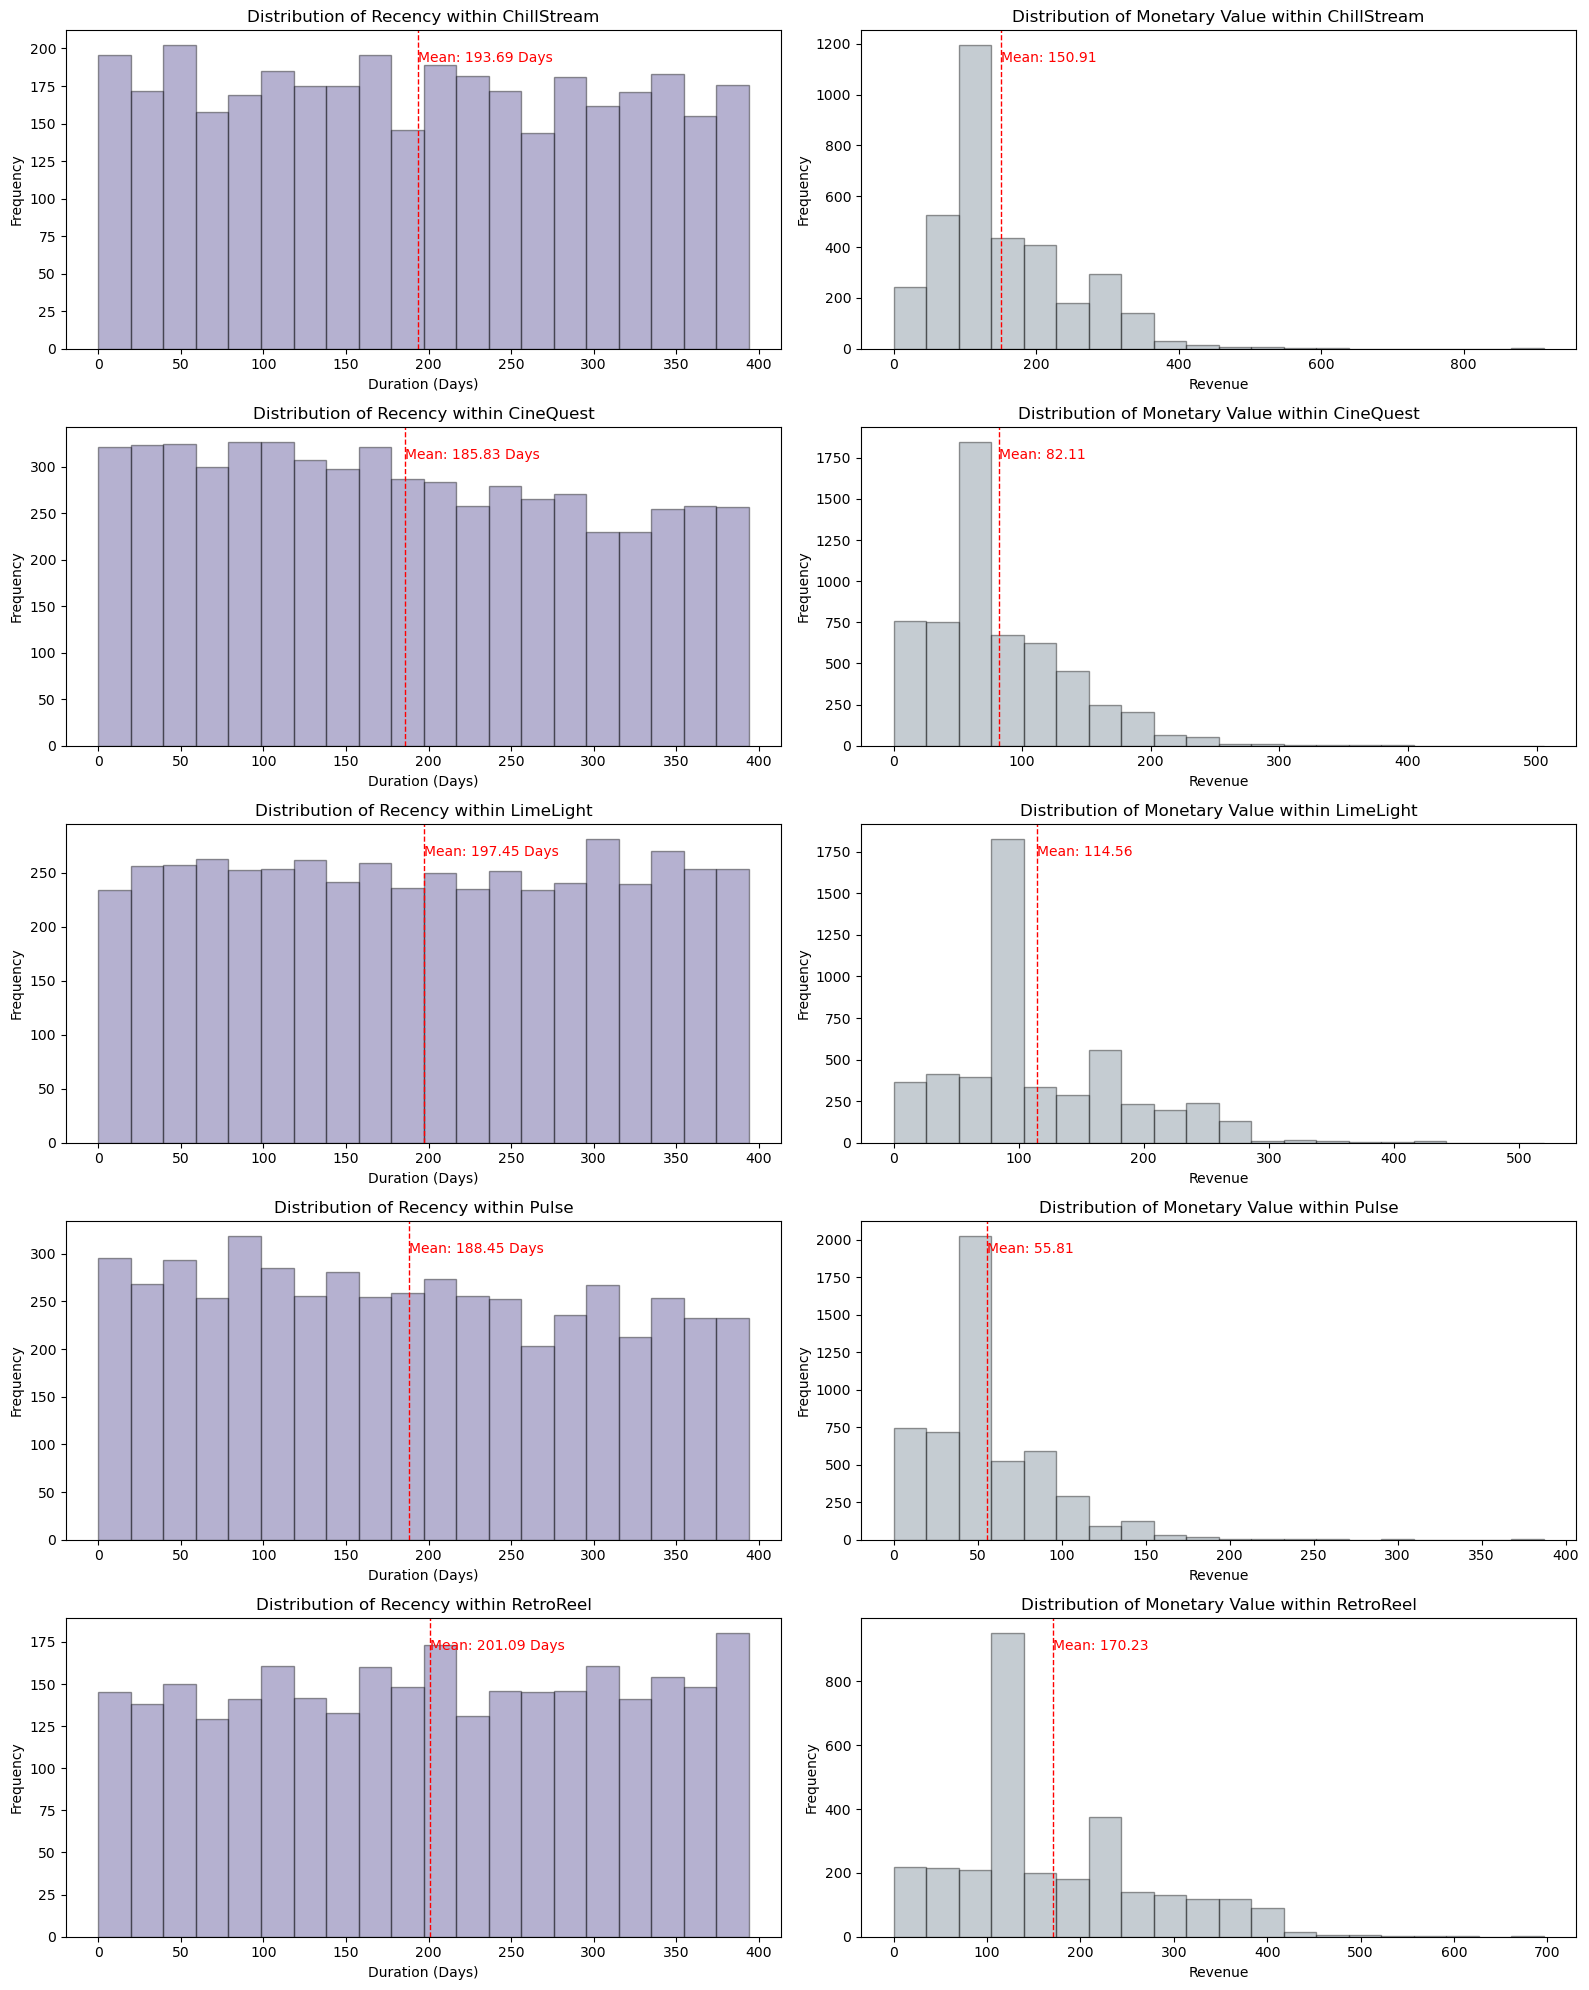

In [71]:
nrows, ncols = 5, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 20))
fig.tight_layout(pad=5.0)  # Add spacing between plots

test_x_brand_grouped = test_x_rfm.groupby('BRAND')

for (ax1, ax2), (brand, brand_group) in zip(axes, test_x_brand_grouped):
    brand_group = brand_group.reset_index(drop=True)
    
    avg_recency_brand = np.mean(brand_group['RECENCY'])
    ax1.hist(brand_group['RECENCY'], color='darkslateblue', alpha=0.4, bins=20, edgecolor='black')
    ax1.axvline(avg_recency_brand, color='r', linestyle='dashed', linewidth=1)
    ax1.text(avg_recency_brand, ax1.get_ylim()[1] * 0.9, 
                   f'Mean: {avg_recency_brand:.2f} Days', color='r')
    ax1.set_title('Distribution of Recency within ' + str(brand))
    ax1.set_xlabel('Duration (Days)')
    ax1.set_ylabel('Frequency')

    avg_revenue_brand = np.mean(brand_group['REVENUE'])
    ax2.hist(brand_group['REVENUE'], color='slategrey', alpha=0.4, bins=20, edgecolor='black')
    ax2.axvline(avg_revenue_brand, color='r', linestyle='dashed', linewidth=1)
    ax2.text(avg_revenue_brand, ax2.get_ylim()[1] * 0.9, f'Mean: {avg_revenue_brand:.2f}', color='r')
    ax2.set_title('Distribution of Monetary Value within ' + str(brand))
    ax2.set_xlabel('Revenue')
    ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

##### test y: 2023-07-01 to 2023-12-31

In [73]:
test_y = pd.read_csv('data_preprocessing/test_y.csv')
test_y['PARTITION_DATE'] = pd.to_datetime(test_y['PARTITION_DATE'])

In [74]:
agg_test_y_data = []
grouped_test_y = test_y.groupby(['ID', 'BRAND'])

for (id_brand, group) in grouped_test_y:
    group = group.reset_index(drop=True)

    start_date = pd.to_datetime('2023-07-01')
    end_date = pd.to_datetime('2023-12-31')
    sub_detail = ''
    revenue = 0
    amount = 0
    
    for i, row in group.iterrows():
        sub_status = row['SUB_STATUS']
        partition_date = row['PARTITION_DATE']

        if sub_status in ['trial', 'discounted', 'paid'] and start_date == pd.to_datetime('2023-07-01'):
            start_date = partition_date
            sub_detail = row['SUB_STATUS'] + ' ' + row['TERM']
            
            if sub_status in ['trial', 'discounted']:
                amount = row['AMOUNT']
            elif sub_status == 'paid' and amount != 0: 
                if row['TERM'] == 'monthly':
                    revenue += np.ceil(duration / 30) * amount
                else:
                    revenue += np.ceil(duration / 365) * amount
                amount = row['AMOUNT']
            
        if sub_status == 'expired':
            end_date = partition_date
            duration = (end_date - start_date).days
            if start_date == pd.to_datetime('2023-07-01'):
                sub_detail = row['SUB_STATUS'] + ' ' + row['TERM']

            if row['TERM'] == 'monthly':
                revenue += np.ceil(duration / 30) * row['AMOUNT']
            else:
                revenue += np.ceil(duration / 365) * row['AMOUNT']
            
            agg_test_y_data.append({
                'ID': id_brand[0],
                'BRAND': id_brand[1],
                'SUB_DETAIL': sub_detail,
                'START_DATE': start_date,
                'END_DATE': end_date,
                'SUB_DURATION_DAYS': duration,
                'REVENUE': revenue
            })            
            start_date = pd.to_datetime('2023-07-01')

agg_test_y = pd.DataFrame(agg_test_y_data)
agg_test_y.head()

,ID,BRAND,SUB_DETAIL,START_DATE,END_DATE,SUB_DURATION_DAYS,REVENUE
0,000AHHU956,RetroReel,expired monthly,2023-07-01,2023-10-28,119,120.00
1,000BRHY264,CineQuest,expired annual,2023-07-01,2023-10-17,108,60.00
2,000JNLK053,CineQuest,expired monthly,2023-07-01,2023-11-23,145,59.90
3,000KGEM860,CineQuest,expired monthly,2023-07-01,2023-11-17,139,60.05
4,000ORNZ823,CineQuest,expired monthly,2023-07-01,2023-12-12,164,72.00


In [75]:
print(test_y.shape, agg_test_y.shape)

(27483, 9) (11005, 7)


In [76]:
agg_test_y.isnull().any()

ID                   False
BRAND                False
SUB_DETAIL           False
START_DATE           False
END_DATE             False
SUB_DURATION_DAYS    False
REVENUE              False
dtype: bool

In [77]:
agg_test_y.describe(include='all')

,ID,BRAND,SUB_DETAIL,START_DATE,END_DATE,SUB_DURATION_DAYS,REVENUE
count,11005,11005,11005,11005,11005,11005.000000,11005.000000
unique,10480,5,8,NaN,NaN,NaN,NaN
top,182JPKB006,CineQuest,expired monthly,NaN,NaN,NaN,NaN
freq,4,3186,7104,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,2023-07-08 04:50:13.466605824,2023-09-30 02:43:10.168105472,83.911767,59.888799
min,NaN,NaN,NaN,2023-07-01 00:00:00,2023-07-01 00:00:00,0.000000,0.000000
25%,NaN,NaN,NaN,2023-07-01 00:00:00,2023-08-15 00:00:00,39.000000,30.000000
50%,NaN,NaN,NaN,2023-07-01 00:00:00,2023-09-30 00:00:00,80.000000,50.010000
75%,NaN,NaN,NaN,2023-07-01 00:00:00,2023-11-15 00:00:00,127.000000,80.000000
max,NaN,NaN,NaN,2023-11-30 00:00:00,2023-12-31 00:00:00,183.000000,210.070000


In [95]:
agg_test_y.to_csv('data_preprocessing/test_y_duration_revenue.csv')

In [101]:
current_date = pd.to_datetime("2023-12-31")
test_y_rfm = agg_test_y.groupby(["ID", "BRAND"], as_index=False).agg(
    RECENCY = ("END_DATE", lambda x: (current_date - x.max()).days),
    FREQUENCY = ('BRAND', 'nunique'),
    REVENUE = ("REVENUE", "sum"),
    SUB = ('SUB_DETAIL', lambda x: list(x)),
    DATE = ("END_DATE", lambda x: x.max())
)
test_y_rfm.head()

,ID,BRAND,RECENCY,FREQUENCY,REVENUE,SUB,DATE
0,000AHHU956,RetroReel,64,1,120.00,[expired monthly],2023-10-28
1,000BRHY264,CineQuest,75,1,60.00,[expired annual],2023-10-17
2,000JNLK053,CineQuest,38,1,59.90,[expired monthly],2023-11-23
3,000KGEM860,CineQuest,44,1,60.05,[expired monthly],2023-11-17
4,000ORNZ823,CineQuest,19,1,72.00,[expired monthly],2023-12-12


In [102]:
test_y_rev = test_y_rfm.REVENUE
test_y_rev.head()

0    120.00
1     60.00
2     59.90
3     60.05
4     72.00
Name: REVENUE, dtype: float64

In [103]:
test_y_rfm.to_csv('data_preprocessing/test_y_rfm.csv')

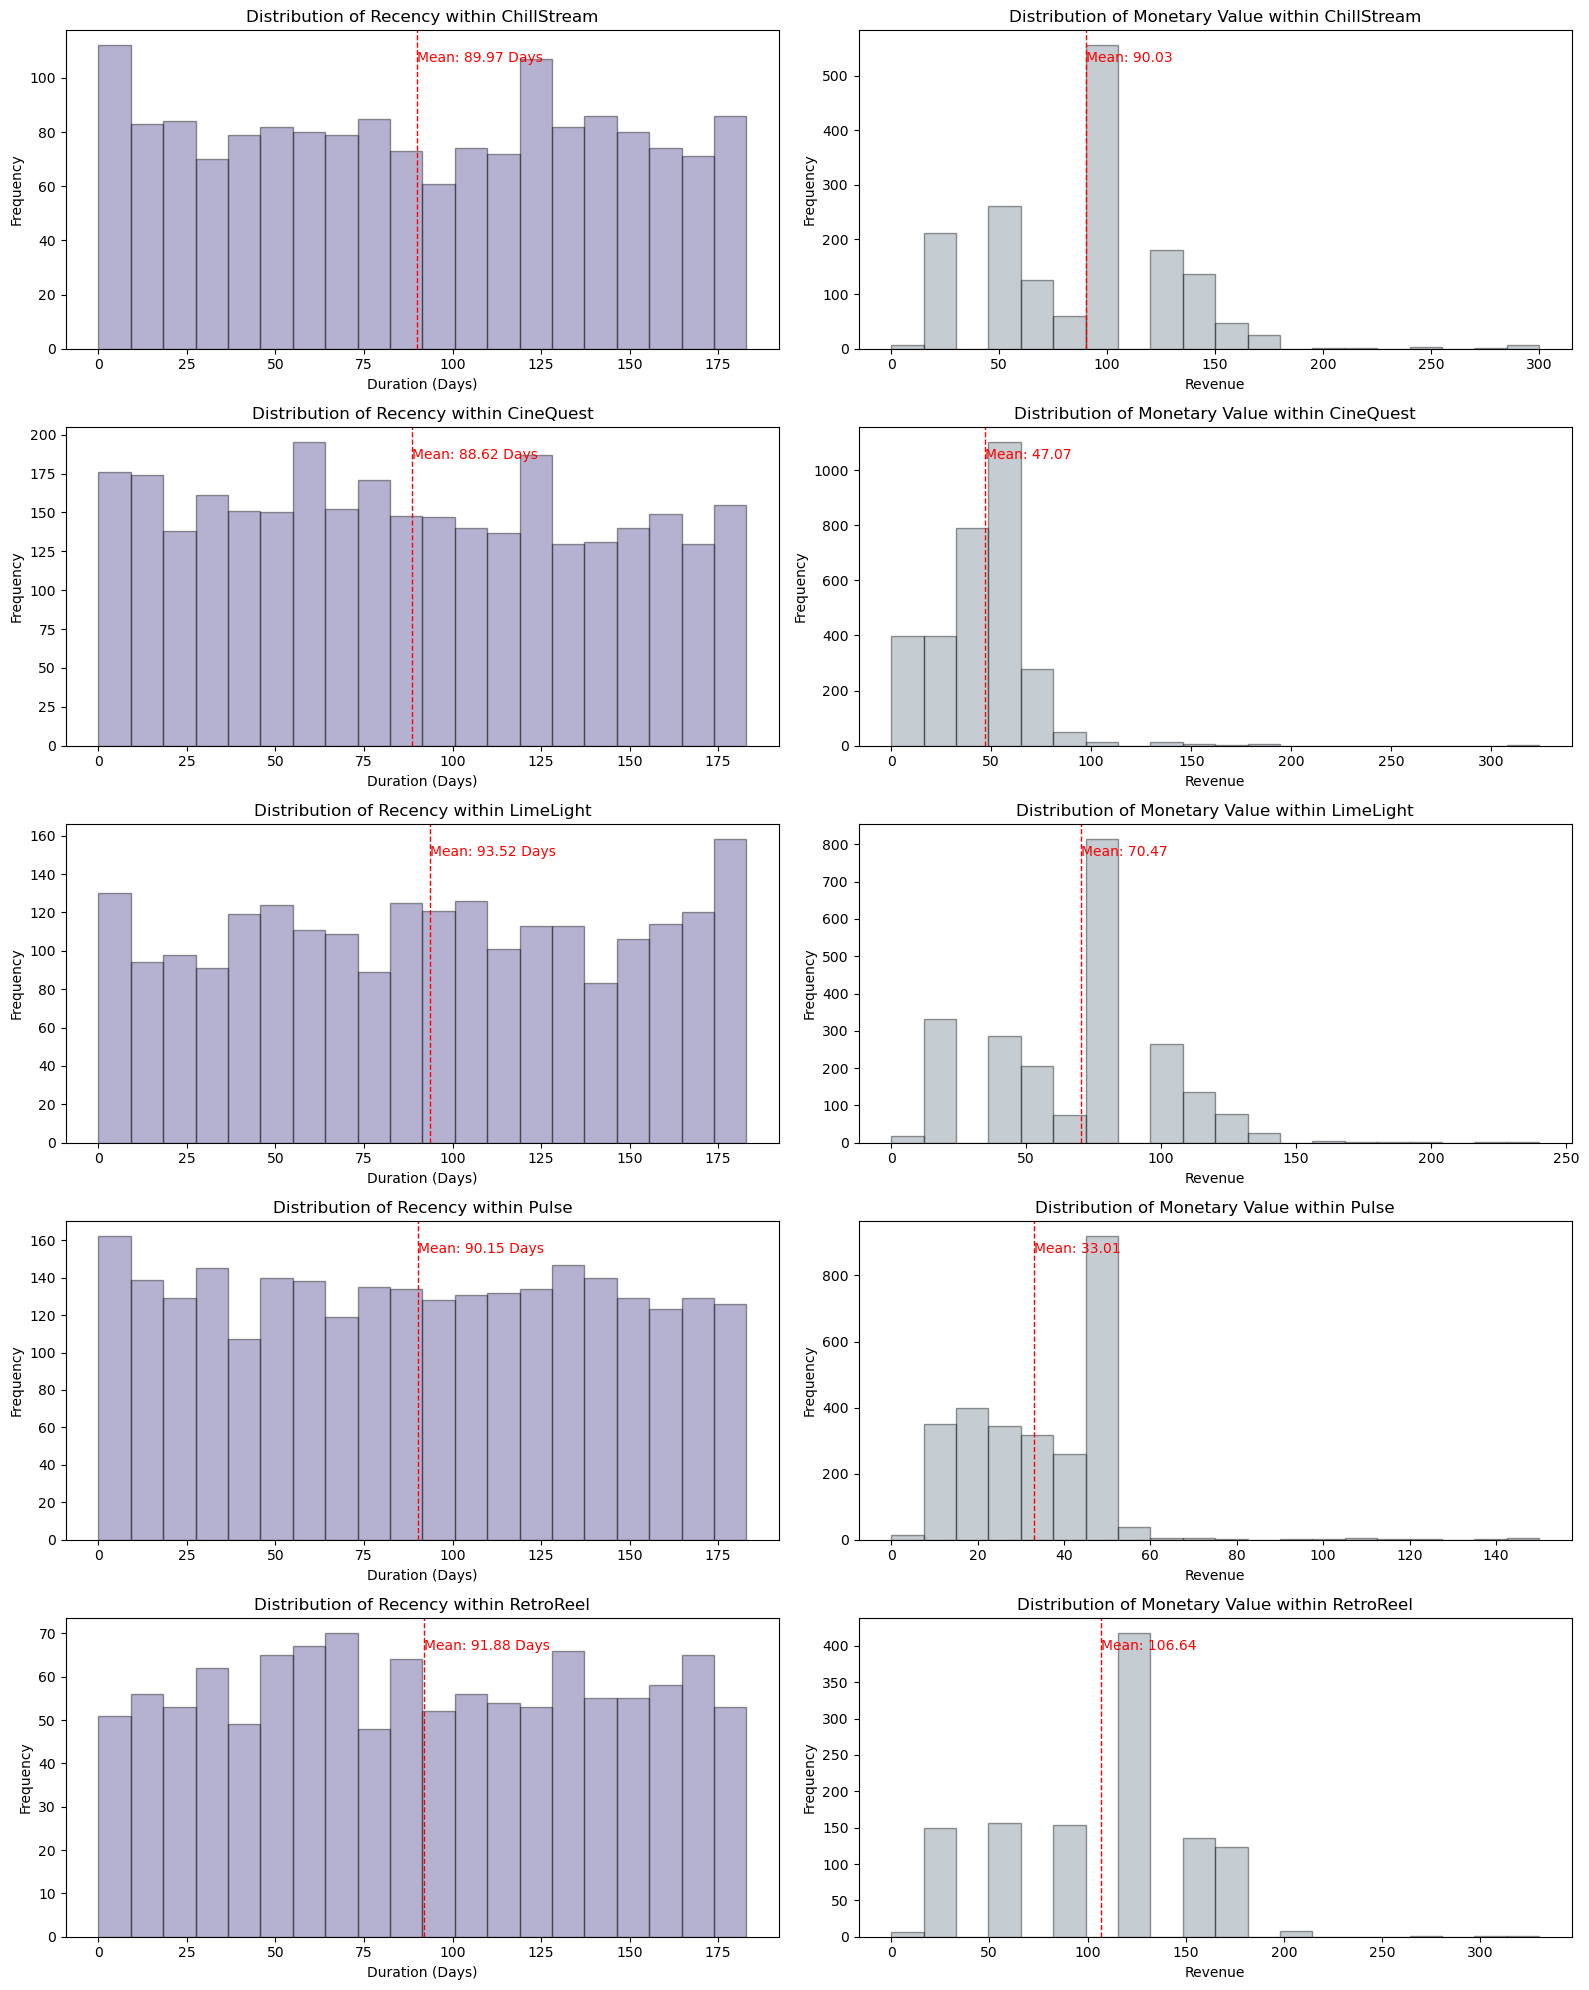

In [82]:
nrows, ncols = 5, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 20))
fig.tight_layout(pad=5.0)  # Add spacing between plots

test_y_brand_grouped = test_y_rfm.groupby('BRAND')

for (ax1, ax2), (brand, brand_group) in zip(axes, test_y_brand_grouped):
    brand_group = brand_group.reset_index(drop=True)
    
    avg_recency_brand = np.mean(brand_group['RECENCY'])
    ax1.hist(brand_group['RECENCY'], color='darkslateblue', alpha=0.4, bins=20, edgecolor='black')
    ax1.axvline(avg_recency_brand, color='r', linestyle='dashed', linewidth=1)
    ax1.text(avg_recency_brand, ax1.get_ylim()[1] * 0.9, 
                   f'Mean: {avg_recency_brand:.2f} Days', color='r')
    ax1.set_title('Distribution of Recency within ' + str(brand))
    ax1.set_xlabel('Duration (Days)')
    ax1.set_ylabel('Frequency')

    avg_revenue_brand = np.mean(brand_group['REVENUE'])
    ax2.hist(brand_group['REVENUE'], color='slategrey', alpha=0.4, bins=20, edgecolor='black')
    ax2.axvline(avg_revenue_brand, color='r', linestyle='dashed', linewidth=1)
    ax2.text(avg_revenue_brand, ax2.get_ylim()[1] * 0.9, f'Mean: {avg_revenue_brand:.2f}', color='r')
    ax2.set_title('Distribution of Monetary Value within ' + str(brand))
    ax2.set_xlabel('Revenue')
    ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

##### predict x: 2023-01-01 to 2023-12-31

In [84]:
predict_X = pd.read_csv('data_preprocessing/predict_x.csv')
predict_X['PARTITION_DATE'] = pd.to_datetime(predict_X['PARTITION_DATE'])

In [85]:
agg_pred_x_data = []
grouped_pred_x = predict_X.groupby(['ID', 'BRAND'])

for (id_brand, group) in grouped_pred_x:
    group = group.reset_index(drop=True)

    start_date = pd.to_datetime('2023-01-01')
    end_date = pd.to_datetime('2023-12-31')
    sub_detail = ''
    revenue = 0
    amount = 0
    
    for i, row in group.iterrows():
        sub_status = row['SUB_STATUS']
        partition_date = row['PARTITION_DATE']

        if sub_status in ['trial', 'discounted', 'paid'] and start_date == pd.to_datetime('2023-01-01'):
            start_date = partition_date
            sub_detail = row['SUB_STATUS'] + ' ' + row['TERM']
            
            if sub_status in ['trial', 'discounted']:
                amount = row['AMOUNT']
            elif sub_status == 'paid' and amount != 0: 
                if row['TERM'] == 'monthly':
                    revenue += np.ceil(duration / 30) * amount
                else:
                    revenue += np.ceil(duration / 365) * amount
                amount = row['AMOUNT']
            
        if sub_status == 'expired':
            end_date = partition_date
            duration = (end_date - start_date).days
            if start_date == pd.to_datetime('2023-01-01'):
                sub_detail = row['SUB_STATUS'] + ' ' + row['TERM']

            if row['TERM'] == 'monthly':
                revenue += np.ceil(duration / 30) * row['AMOUNT']
            else:
                revenue += np.ceil(duration / 365) * row['AMOUNT']
            
            agg_pred_x_data.append({
                'ID': id_brand[0],
                'BRAND': id_brand[1],
                'SUB_DETAIL': sub_detail,
                'START_DATE': start_date,
                'END_DATE': end_date,
                'SUB_DURATION_DAYS': duration,
                'REVENUE': revenue
            })            
            start_date = pd.to_datetime('2023-01-01')

agg_pred_x = pd.DataFrame(agg_pred_x_data)
agg_pred_x.head()

,ID,BRAND,SUB_DETAIL,START_DATE,END_DATE,SUB_DURATION_DAYS,REVENUE
0,000AHHU956,RetroReel,expired monthly,2023-01-01,2023-10-28,300,300.00
1,000BRHY264,CineQuest,expired annual,2023-01-01,2023-10-17,289,60.00
2,000ELOE240,LimeLight,expired annual,2023-01-01,2023-04-25,114,80.01
3,000GTIY258,Pulse,expired monthly,2023-01-01,2023-01-03,2,7.98
4,000JNLK053,CineQuest,expired monthly,2023-01-01,2023-11-23,326,131.78


In [86]:
print(predict_X.shape, agg_pred_x.shape)

(55769, 9) (21983, 7)


In [87]:
agg_pred_x.isnull().any()

ID                   False
BRAND                False
SUB_DETAIL           False
START_DATE           False
END_DATE             False
SUB_DURATION_DAYS    False
REVENUE              False
dtype: bool

In [88]:
agg_pred_x.describe(include='all')

,ID,BRAND,SUB_DETAIL,START_DATE,END_DATE,SUB_DURATION_DAYS,REVENUE
count,21983,21983,21983,21983,21983,21983.000000,21983.000000
unique,18953,5,8,NaN,NaN,NaN,NaN
top,182JPKB006,CineQuest,expired monthly,NaN,NaN,NaN,NaN
freq,5,6202,11510,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,2023-02-01 17:31:29.332666368,2023-06-30 16:13:47.985261312,148.946049,91.809362
min,NaN,NaN,NaN,2023-01-01 00:00:00,2023-01-01 00:00:00,0.000000,0.000000
25%,NaN,NaN,NaN,2023-01-01 00:00:00,2023-03-30 00:00:00,64.000000,49.980000
50%,NaN,NaN,NaN,2023-01-01 00:00:00,2023-07-01 00:00:00,134.000000,75.000000
75%,NaN,NaN,NaN,2023-01-22 00:00:00,2023-09-30 00:00:00,225.000000,120.000000
max,NaN,NaN,NaN,2023-11-30 00:00:00,2023-12-31 00:00:00,364.000000,390.260000


In [89]:
agg_pred_x.to_csv('data_preprocessing/pred_x_duration_revenue.csv')

In [99]:
current_date = pd.to_datetime("2023-12-31")
pred_x_rfm = agg_pred_x.groupby(["ID", "BRAND"], as_index=False).agg(
    RECENCY = ("END_DATE", lambda x: (current_date - x.max()).days),
    FREQUENCY = ('BRAND', 'nunique'),
    REVENUE = ("REVENUE", "sum"),
    SUB = ('SUB_DETAIL', lambda x: list(x)),
    DATE = ("END_DATE", lambda x: x.max())
)
pred_x_rfm.head()

,ID,BRAND,RECENCY,FREQUENCY,REVENUE,SUB,DATE
0,000AHHU956,RetroReel,64,1,300.00,[expired monthly],2023-10-28
1,000BRHY264,CineQuest,75,1,60.00,[expired annual],2023-10-17
2,000ELOE240,LimeLight,250,1,80.01,[expired annual],2023-04-25
3,000GTIY258,Pulse,362,1,7.98,[expired monthly],2023-01-03
4,000JNLK053,CineQuest,38,1,131.78,[expired monthly],2023-11-23


In [100]:
pred_x_rfm.to_csv('data_preprocessing/pred_x_rfm.csv')

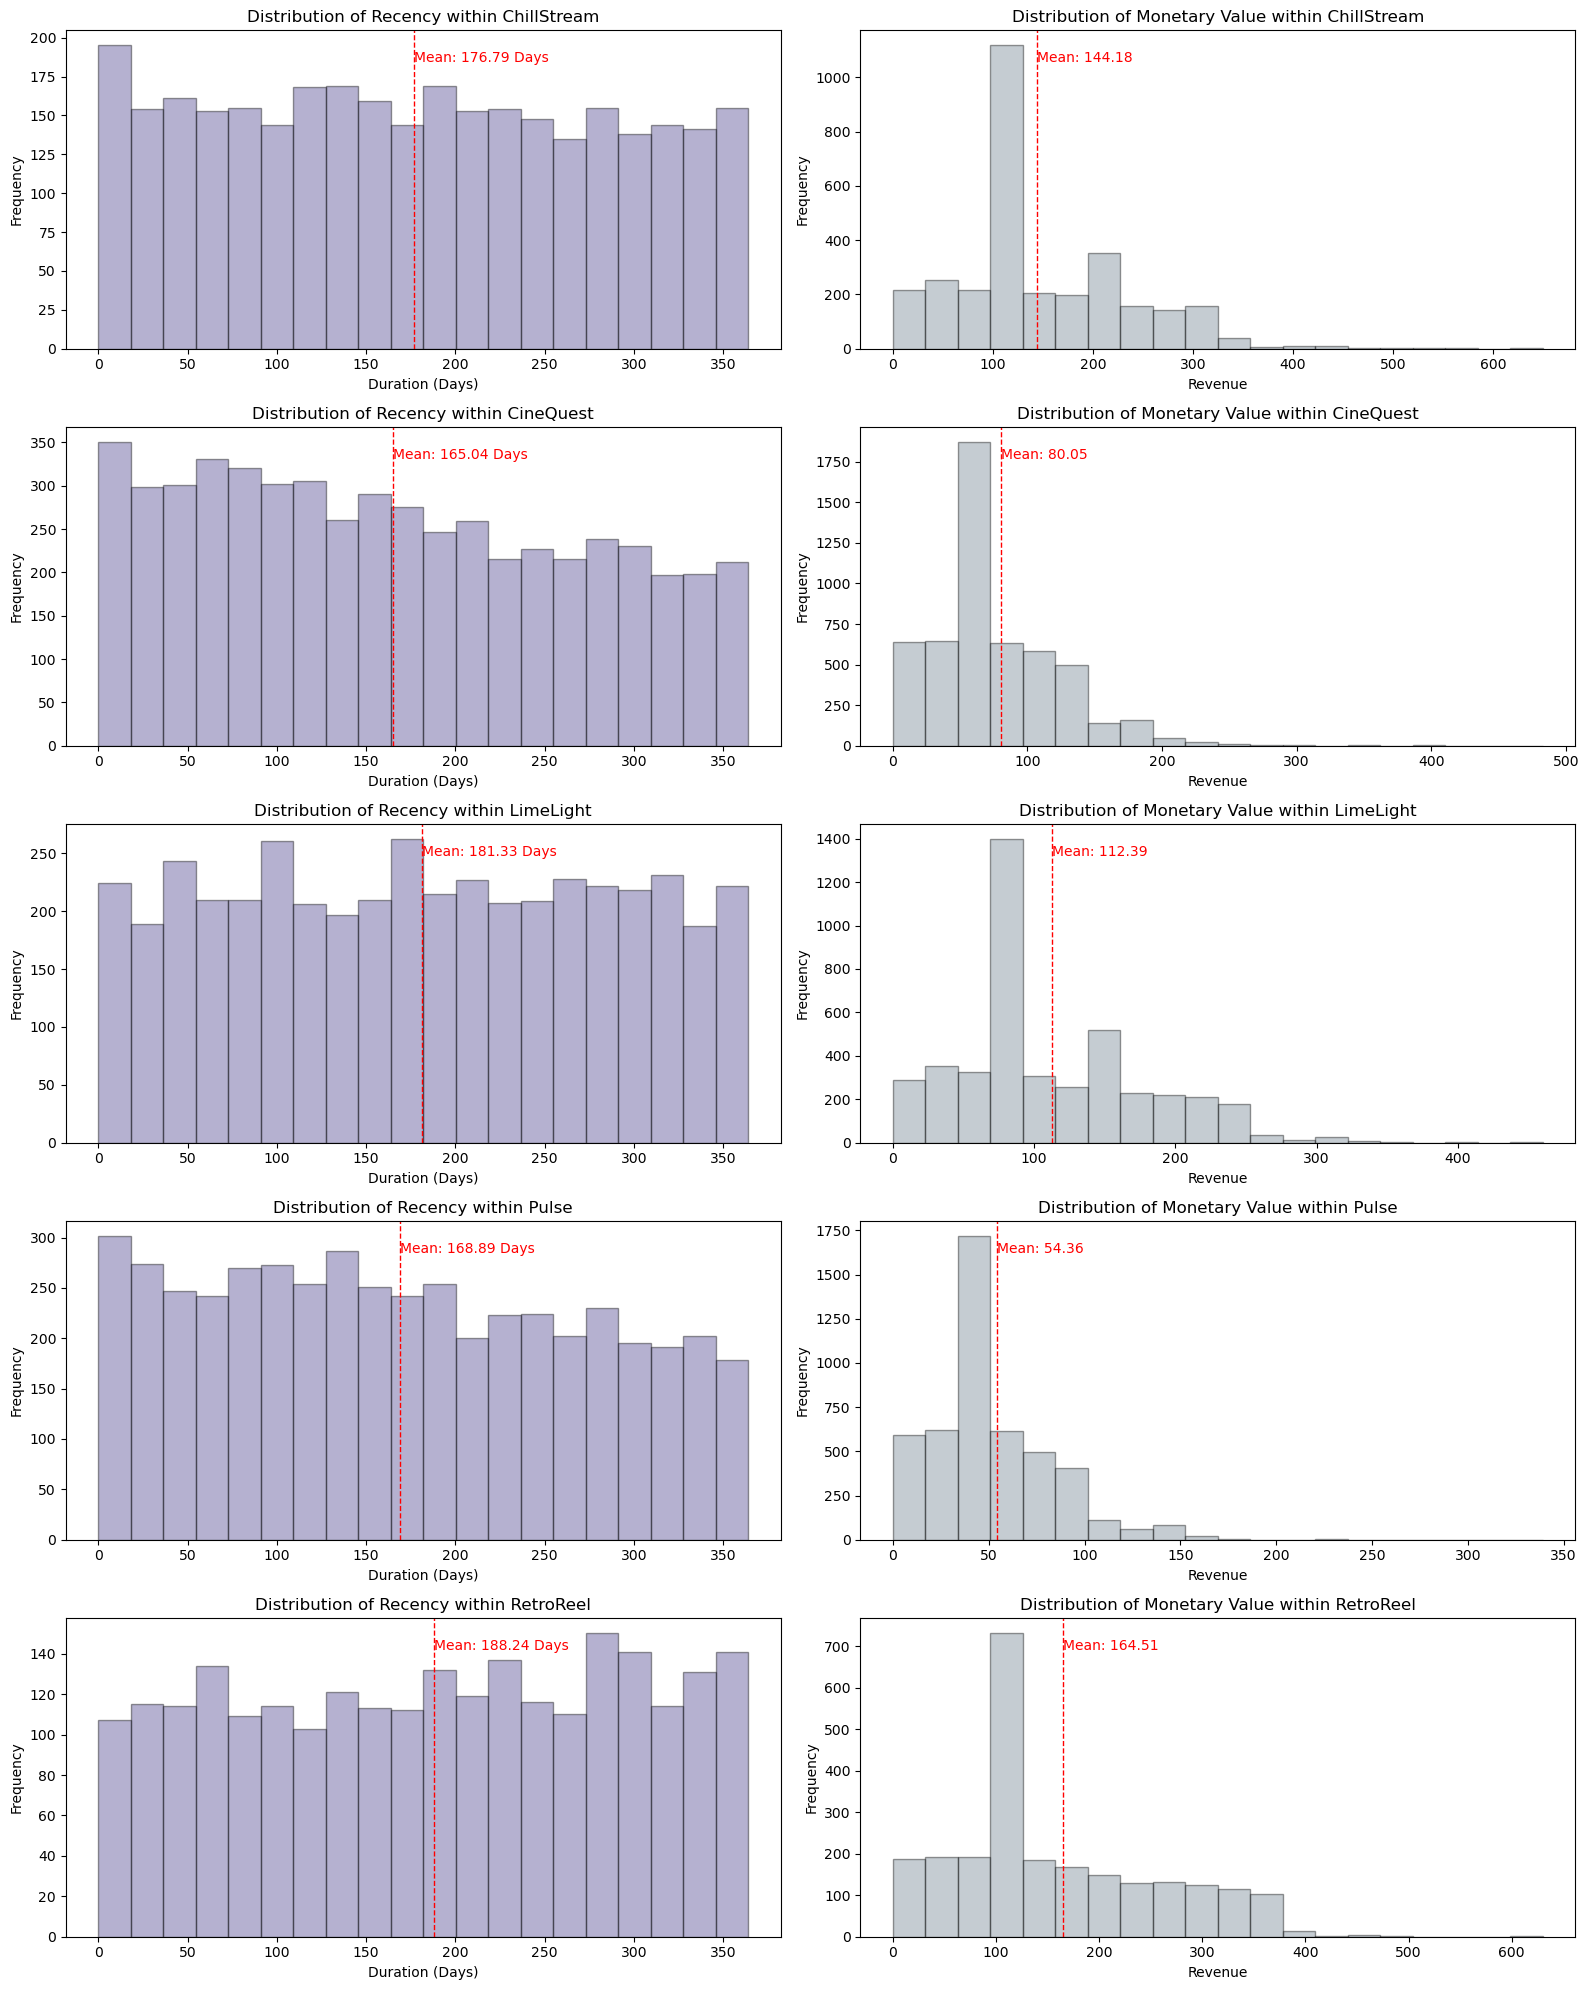

In [92]:
nrows, ncols = 5, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 20))
fig.tight_layout(pad=5.0)  # Add spacing between plots

pred_x_brand_grouped = pred_x_rfm.groupby('BRAND')

for (ax1, ax2), (brand, brand_group) in zip(axes, pred_x_brand_grouped):
    brand_group = brand_group.reset_index(drop=True)
    
    avg_recency_brand = np.mean(brand_group['RECENCY'])
    ax1.hist(brand_group['RECENCY'], color='darkslateblue', alpha=0.4, bins=20, edgecolor='black')
    ax1.axvline(avg_recency_brand, color='r', linestyle='dashed', linewidth=1)
    ax1.text(avg_recency_brand, ax1.get_ylim()[1] * 0.9, 
                   f'Mean: {avg_recency_brand:.2f} Days', color='r')
    ax1.set_title('Distribution of Recency within ' + str(brand))
    ax1.set_xlabel('Duration (Days)')
    ax1.set_ylabel('Frequency')

    avg_revenue_brand = np.mean(brand_group['REVENUE'])
    ax2.hist(brand_group['REVENUE'], color='slategrey', alpha=0.4, bins=20, edgecolor='black')
    ax2.axvline(avg_revenue_brand, color='r', linestyle='dashed', linewidth=1)
    ax2.text(avg_revenue_brand, ax2.get_ylim()[1] * 0.9, f'Mean: {avg_revenue_brand:.2f}', color='r')
    ax2.set_title('Distribution of Monetary Value within ' + str(brand))
    ax2.set_xlabel('Revenue')
    ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [93]:
# sub_duration[sub_duration.SUB_DETAIL.str.contains('annual')]

In [94]:
# nrows, ncols = 1, 2

# # Create the 3x2 subplot grid
# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10))
# fig.tight_layout(pad=5.0)  # Add spacing between plots

# # Flatten the axes array for easier indexing
# axes = axes.flatten()

# avg_recency = np.mean(id_brand_agg['RECENCY'])
# axes[0].hist(id_brand_agg['RECENCY'], color='darkslateblue', alpha=0.4, bins=20, edgecolor='black')
# axes[0].axvline(avg_recency, color='r', linestyle='dashed', linewidth=1)
# axes[0].text(avg_recency, axes[0].get_ylim()[1] * 0.9, f'Mean: {avg_duration:.2f} Days', color='r')
# axes[0].set_title('Distribution of Recency')
# axes[0].set_xlabel('Recency (Days)')
# axes[0].set_ylabel('Frequency')

# avg_revenue = np.mean(id_brand_agg['REVENUE'])
# axes[1].hist(id_brand_agg['REVENUE'], color='slategrey', alpha=0.4, bins=20, edgecolor='black')
# axes[1].axvline(avg_revenue, color='r', linestyle='dashed', linewidth=1)
# axes[1].text(avg_revenue, axes[1].get_ylim()[1] * 0.9, f'Mean: {avg_revenue:.2f}', color='r')
# axes[1].set_title('Distribution of Monetary Value')
# axes[1].set_xlabel('Revenue')
# axes[1].set_ylabel('Frequency')